In [4]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [38]:
# TODO: 是否应该把本程序中的函数作为class实现？

In [37]:
# 判断依据
# 发光持续时间（光强曲线下降率？若干时间间隔中的光子计数？）
# 切伦科夫光？ 前10ns的光子信息
# 傅里叶分析？

In [35]:
# 数据读入（完整读入约半分钟）
# 开头大写对应有多个项目的列表（一个三维坐标认为只有一个项目）

# train.h5中的PEGuess数据过于诡异
# 采用'PETruth'中的光子发生数据作为依据
with h5py.File('data/train.h5', 'r') as ipt:
    Wave = ipt['Waveform'][...]
    PE_truth = ipt['PETruth'][...]
    Par_truth = ipt['ParticleTruth'][...]

In [20]:
# PMT_position： (30, 3)的numpy数组，对应各个探测器位置
# radius: 探测器半径
 
PMT_position = pd.read_csv('data/PMT.csv').to_numpy()[:, 1:4]
radius = min(np.sqrt((PMT_position ** 2).sum(axis=1)))

In [22]:
# TODO：光速，是否应该采用液闪中光速？以及液闪折射率是否1.5？

c0 = 299792458e-6 / 1.5

In [24]:
def read_event(eve):
    '''
    读入指定事件的相关数据(全部读入至全局变量中)
        input:
            eve             事件的id
        output:
            PE_eve          该事件中的所有PE信息
            Counts_eve      每个探测器接受到的光子数，(30,)的numpy数组
            Prob0_eve       对探测器接受光子数归一化的结果，(30,)的numpy数组
    '''
    global PE_eve, Counts_eve, Prob0_eve
    PE_eve = PE_truth[PE_truth['EventID'] == eve]
    Counts_eve = np.bincount(PE_eve['ChannelID'] * 1, minlength=30)
    Prob0_eve = Counts_eve / Counts_eve.sum()

In [36]:
def cal_position_score(_position):
    '''
    为了反溯光子源位置，需要对猜测的可能位置打分
        为了使用minimize，以低分表示好结果
        算法：
            由于切伦科夫相对闪烁光为小量，而闪烁光近似各向同性
            认为探测器上的光子数与至光源的距离满足平方反比关系。
            目前采用的方法是最大似然估计
            TODO: 其它可行的方法有待尝试，如TraceDistance, Fidelity (或者直接机器学习)
        input: 
            _position           (3,)numpy数组，依此对应x, y, z
        output:
            score               对应_position的分数，越低越好
        
    '''
    global PMT_position, Prob0_eve, Counts_eve
    distance2 = np.sum((PMT_position - _position) ** 2, axis=1)
    Prob = 1 / distance2
    Prob /= Prob.sum()
    prob_log = (np.log(Prob) * Counts_eve).sum()

    return -prob_log

# 约束条件： 光源不能超出球的范围
cons = ({'type': 'ineq', 'fun': lambda x: radius ** 2 - sum(x ** 2)})

def cal_position():
    '''
    计算光源位置
        input:
            请在调用此函数前使用 read_event() 函数
            完成全局变量 Prob0_eve, Counts_eve 的准备
            并完成 PMT_position 的读入
        output:
            (pos:np.arr, flag:bool)         返回二元组
            pos                             计算得到的位置
            flag                            是否运算成功   
    '''
    pos0 = np.array([0, 0, 0])
    res = minimize(cal_position_score, pos0, method='SLSQP', constraints=cons)
    return (res.x, res.success)

In [39]:
def cal_PE_time(eve=-1):
    '''
    计算eve事件中光源发出每个光子的真实时间,
        存至全局变量 PE_time (不排序，使得其仍与PE_truth对应)
        input:
            eve         需要检测的事件编号，不输入则采用当前全局变量
        output:
            flag_pos    是否成功检验
            PE_time     全局变量，一维numpy数组      
    '''
    global c0, PMT
    global PE_time
    if eve != -1:
        read_event(eve)
    (pos, flag_pos) = cal_position()
    
    Distance2 = np.sum((PMT_position - pos) ** 2, axis=1)
    Distance = np.sqrt(Distance2)
    Time_delay = Distance / c0

    PE_time = PE_eve['PETime'] - Time_delay[PE_eve['ChannelID']]

    return flag_pos


In [43]:
# 代码使用样例
if 0:
    print(cal_PE_time(9))
    print(PE_time)

In [45]:
def cal_density(time, sigma=3):
    '''
    基于 PE_time 计算各个时刻的光子密度
        采用高斯分布将光子的计数结果进行弥散（保证每个弥散的波包归一化）
        PE_time 需要预先初始化
    input:
        time            一维numpy数组，表示若干需要查询的时刻值
        sigma           波包的弥散程度，即高斯波包的标准差  
    output:
        density_time    一维numpy数组，每个对应时刻的光子强度

    '''
    global PE_time
    return np.sum(np.exp(- ((np.expand_dims(time, 1) - PE_time) ** 2) / (2 * (sigma ** 2))) \
                  / (2 * np.pi * sigma), axis=1)

In [49]:
level_rate = 1 / 10

# 对应时间范围内发光强度变换的计算
Time = np.arange(PE_eve['PETime'].min() - 50, PE_eve['PETime'].max() + 50, 1)
Rate = cal_density(Time)

rate_max = np.max(Rate)
rate_level = rate_max * level_rate

# 计算从最大值 max 降落至 max * level_rate 的用时
# 以 >= 64或66为依据，有65%至67%的准确率
id_max = np.where(Rate >= rate_max * 0.999)[0][0]
characteristics_time = (Rate[id_max:] >= rate_level).sum()
print(characteristics_time)

69


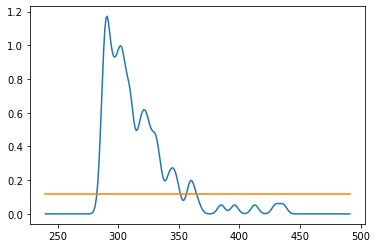

In [51]:
Rate_level = np.full_like(Time, rate_level, dtype=np.double)



plt.plot(Time, Rate)
plt.plot(Time, Rate_level)
plt.show()